In [470]:
!pip install pmdarima

In [471]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import DateOffset

In [472]:
filename = 'Datos_Prueba_DataScientist.csv'

df = pd.read_csv(filename)
df.head(2).append(df.tail(2))

,OrderId,RequestTime,DeliveryOption
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm
153273,PED_153274,2021-02-28 17:53:28,Siguiente dia entre las 6:30 pm y 8:30 pm
153274,PED_153275,2021-02-28 17:53:41,Siguiente dia entre 12:30 pm y 2:30 pm


In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153275 entries, 0 to 153274
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   OrderId         153275 non-null  object
 1   RequestTime     153275 non-null  object
 2   DeliveryOption  153275 non-null  object
dtypes: object(3)
memory usage: 3.5+ MB


#### There aren't any null values

In [474]:
df['OrderId'] = df['OrderId'].str.split("_", expand=True)[1]
df['RequestTime'] = pd.to_datetime(df['RequestTime'])
df['DeliveryOption'] = df['DeliveryOption'].astype('category')

In [475]:
df.DeliveryOption.dtypes

CategoricalDtype(categories=['Mismo dia entre 6:30 pm y 8:30 pm',
                  'Siguiente dia entre 12:30 pm y 2:30 pm',
                  'Siguiente dia entre las 6:30 pm y 8:30 pm'],
, ordered=False)

In [476]:
DeliveryOptions = {'Mismo dia entre 6:30 pm y 8:30 pm': '1',
                  'Siguiente dia entre 12:30 pm y 2:30 pm': '2',
                  'Siguiente dia entre las 6:30 pm y 8:30 pm': '3'
                  }
df.DeliveryOption.replace(DeliveryOptions, inplace=True)
df.DeliveryOption = df.DeliveryOption.astype('category')

Delivery Options:
- Option 1. Same day between 6:30PM and 8:30PM
- Option 2. Next day between 12:30PM and 2:30PM
- Option 3. Next day between 6:30PM and 8:30PM

In [477]:
hours = df['RequestTime'].dt.hour
morning_shift = 0
night_shift = 0
for i in range(len(df)):
    if hours[i] <= 12:
        morning_shift += 1
    else:
        night_shift += 1
print('Morning Shift:', morning_shift)
print('Night Shift:', night_shift)
print('Total:', morning_shift + night_shift)

Morning Shift: 119814
Night Shift: 33461
Total: 153275


In [478]:
shifts = df.groupby([df['RequestTime'].dt.year, df['RequestTime'].dt.month, df['RequestTime'].dt.hour <= 12])['OrderId'].count()
shifts.index.names = ['Year', 'Month', 'Morning Shift?']
shifts

Year  Month  Morning Shift?
2018  1      False              225
             True               601
      2      False              192
             True               541
      3      False              245
                               ... 
2020  12     True              6940
2021  1      False             1560
             True              6046
      2      False             1285
             True              4735
Name: OrderId, Length: 76, dtype: int64

<AxesSubplot:xlabel='Year,Month,Morning Shift?'>

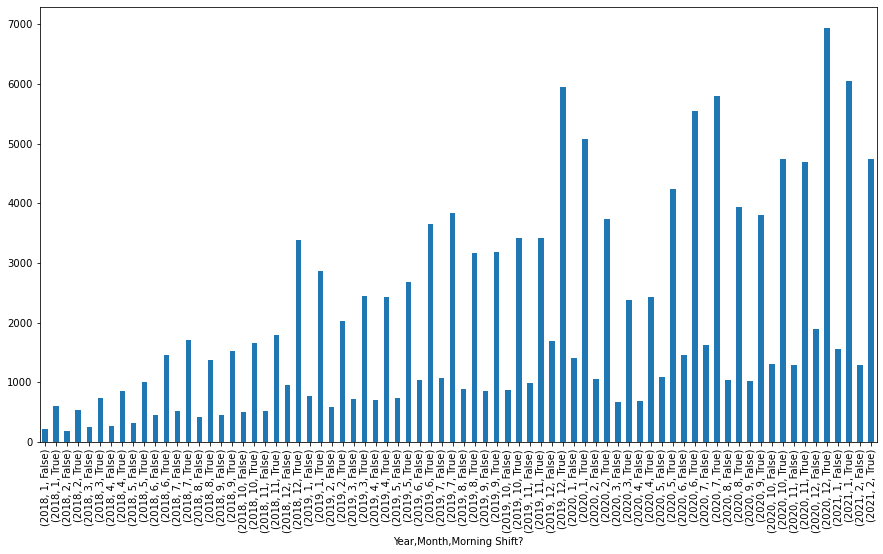

In [479]:
shifts.plot.bar(figsize=(15, 8))

Year  Month
2018  1         826
      2         733
      3         979
      4        1121
      5        1324
      6        1924
      7        2227
      8        1808
      9        1976
      10       2162
      11       2305
      12       4350
2019  1        3633
      2        2616
      3        3157
      4        3139
      5        3420
      6        4703
      7        4912
      8        4060
      9        4047
      10       4284
      11       4416
      12       7629
2020  1        6486
      2        4804
      3        3058
      4        3119
      5        5329
      6        6993
      7        7439
      8        4975
      9        4831
      10       6049
      11       5975
      12       8840
2021  1        7606
      2        6020
Name: Orders, dtype: int64

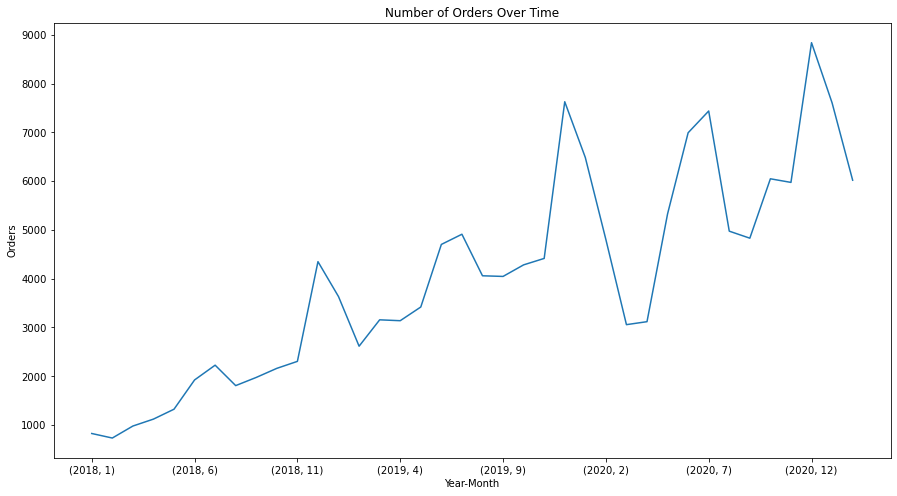

In [480]:
df_model = df.groupby([df['RequestTime'].dt.year, df['RequestTime'].dt.month])['OrderId'].count()
df_model.name = 'Orders'
df_model.index.names = ['Year', 'Month']
df_model.plot(figsize=(15,8), xlabel='Year-Month', ylabel='Orders', title='Number of Orders Over Time')
df_model

In [481]:
dates = pd.date_range(start='2018-01', freq='M', periods=df_model.count())
data = {'Date': dates, 'Orders': df_model.values}
df = pd.DataFrame(data=data)
df.set_index('Date', inplace=True)
df.head(2).append(df.tail(2))

,Orders
Date,
2018-01-31,826
2018-02-28,733
2021-01-31,7606
2021-02-28,6020


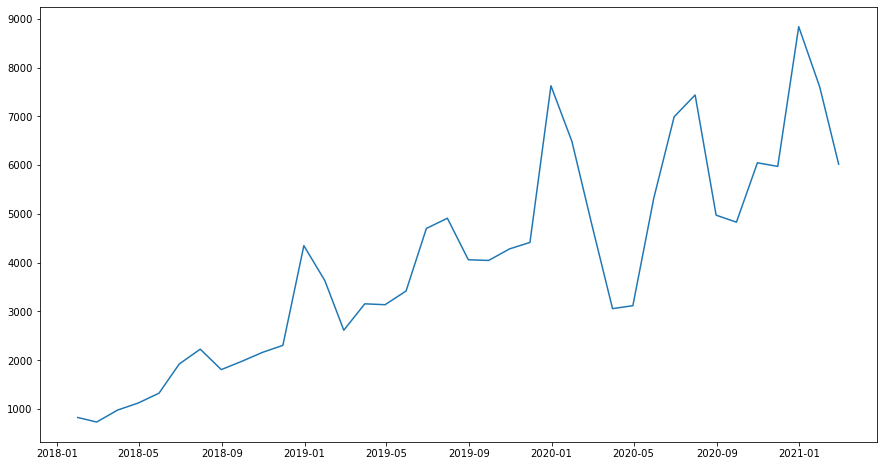

In [482]:
plt.figure(figsize=(15, 8))
plt.plot(df['Orders'])

In [483]:
print(f'ADF Statistic: {adfuller(df)[0]}')
print(f'p-value: {adfuller(df)[1]}')

ADF Statistic: -0.8730613813751525
p-value: 0.7967142162154752


In [484]:
df_diff = df.diff().dropna()

In [485]:
print(f'ADF Statistic: {adfuller(df_diff)[0]}', 'after first difference')
print(f'p-value: {adfuller(df_diff)[1]}' , 'after first difference')

ADF Statistic: -3.7750002810956436 after first difference
p-value: 0.003173705126307902 after first difference


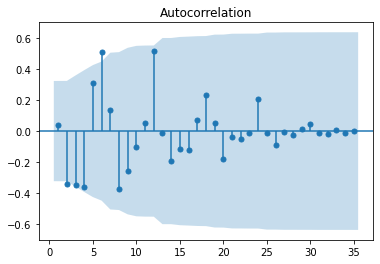

In [486]:
plot_acf(df_diff, lags=35, zero=False);

In [487]:
results = pm.auto_arima(df, seasonal=True, m=6, d=1, D=1, information_criteria='bic', trace=True, error_action='ignore',
                       n_fits=100, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[6]             : AIC=508.677, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=525.333, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=510.526, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=511.887, Time=0.17 sec
 ARIMA(2,1,2)(0,1,1)[6]             : AIC=inf, Time=0.35 sec
 ARIMA(2,1,2)(1,1,0)[6]             : AIC=inf, Time=0.34 sec
 ARIMA(2,1,2)(2,1,1)[6]             : AIC=510.585, Time=0.84 sec
 ARIMA(2,1,2)(1,1,2)[6]             : AIC=509.690, Time=0.70 sec
 ARIMA(2,1,2)(0,1,0)[6]             : AIC=inf, Time=0.11 sec
 ARIMA(2,1,2)(0,1,2)[6]             : AIC=inf, Time=0.63 sec
 ARIMA(2,1,2)(2,1,0)[6]             : AIC=inf, Time=0.79 sec
 ARIMA(2,1,2)(2,1,2)[6]             : AIC=511.300, Time=0.85 sec
 ARIMA(1,1,2)(1,1,1)[6]             : AIC=507.252, Time=0.33 sec
 ARIMA(1,1,2)(0,1,1)[6]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,2)(1,1,0)[6]             : AIC=505.791, Time=0.17 sec
 ARIMA

In [488]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   38
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 6)   Log Likelihood                -248.153
Date:                            Mon, 02 May 2022   AIC                            504.305
Time:                                    22:05:59   BIC                            510.041
Sample:                                         0   HQIC                           506.175
                                             - 38                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2622      0.236     -1.113      0.266      -0.724       0.200
ma.L2         -0.5229      0.231     -2.266      0.023      -0.975      -0.071
ar.S.L6       -0.8580      0.219     -3.916      0.000      -1.287      -0.429
sigma2      4.421e+05   7.79e+04      5.678      0.000    2.89e+05    5.95e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                22.89
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -1.02
Prob(H) (two-sided):                  0.71   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

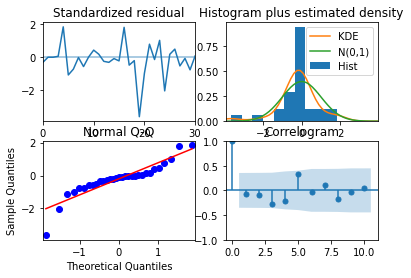

In [489]:
results.plot_diagnostics();

In [490]:
train, test = train_test_split(df, test_size=0.25)

In [491]:
test.shape

(10, 1)

In [492]:
prediction = pd.DataFrame(results.predict(n_periods=test.shape[0]), test.index)
prediction.columns = ['Predicted_Orders']
test['Predicted_Orders'] = prediction

<ipython-input-492-9b61e067aea5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Orders'] = prediction


In [493]:
test

,Orders,Predicted_Orders
Date,,
2020-05-31,5329,4763.807093
2020-06-30,6993,4968.236760
2020-07-31,7439,6853.874385
2020-08-31,4975,8688.434460
2020-09-30,4831,8895.849176
2020-10-31,6049,6556.538390
2020-11-30,5975,6254.590258
2020-12-31,8840,7328.648017
2021-01-31,7606,7532.946053


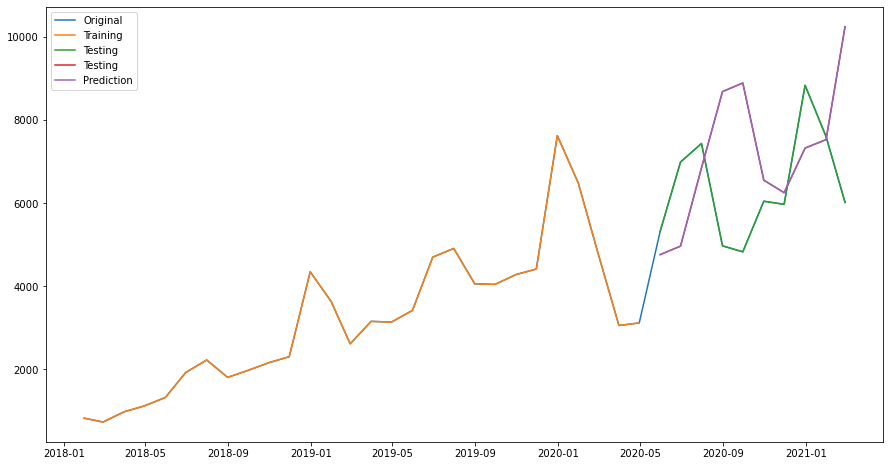

In [494]:
plt.figure(figsize=(15, 8),)
plt.plot(df, label='Original')
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.plot(prediction, label='Prediction')
plt.legend()

In [495]:
df.shape

(38, 1)

In [496]:
future_dates = pd.date_range(start='2021-03', freq='M', periods=10)
future_dates

DatetimeIndex(['2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
               '2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31',
               '2021-11-30', '2021-12-31'],
              dtype='datetime64[ns]', freq='M')

In [497]:
future_dates_df = pd.DataFrame(index=future_dates[:], columns=df.columns)
future_dates_df

,Orders
2021-03-31,NaN
2021-04-30,NaN
2021-05-31,NaN
2021-06-30,NaN
2021-07-31,NaN
2021-08-31,NaN
2021-09-30,NaN
2021-10-31,NaN
2021-11-30,NaN
2021-12-31,NaN


In [498]:
future_dates_df.tail(10)

,Orders
2021-03-31,NaN
2021-04-30,NaN
2021-05-31,NaN
2021-06-30,NaN
2021-07-31,NaN
2021-08-31,NaN
2021-09-30,NaN
2021-10-31,NaN
2021-11-30,NaN
2021-12-31,NaN


In [499]:
future_dates_df.shape

(10, 1)

In [500]:
future_dates_df['Forecast Orders'] = results.predict(n_periods=future_dates_df.shape[0], dynamic=True)

In [501]:
future_df = pd.concat([df, future_dates_df])

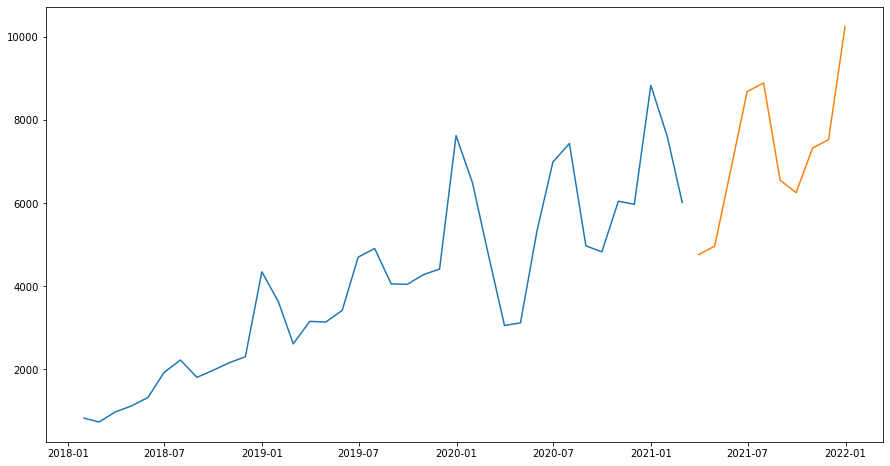

In [502]:
plt.figure(figsize=(15, 8))
plt.plot(future_df)

In [503]:
future_df.tail(10)

,Orders,Forecast Orders
2021-03-31,NaN,4763.807093
2021-04-30,NaN,4968.236760
2021-05-31,NaN,6853.874385
2021-06-30,NaN,8688.434460
2021-07-31,NaN,8895.849176
2021-08-31,NaN,6556.538390
2021-09-30,NaN,6254.590258
2021-10-31,NaN,7328.648017
2021-11-30,NaN,7532.946053
2021-12-31,NaN,10251.608075


In [504]:
orders_march2021 = math.ceil(future_df['Forecast Orders'][-10].sum())
print(f'Expected Orders in March 2021 (next month): {orders_march2021}')

Expected Orders in March 2021 (next month): 4764


In [505]:
orders_march2021_day = math.ceil(orders_march2021/31)

In [506]:
proportion_morning = morning_shift/(morning_shift+night_shift)
proportion_morning

0.7816930353938999

In [507]:
print(f'In March 2021, we will have atleast {orders_march2021_day} orders per day. ABC wants to hire at least {math.ceil((orders_march2021_day/5)*proportion_morning)} employees in the morning and {math.ceil((orders_march2021_day/5)*(1-proportion_morning))} at night')

In March 2021, we will have atleast 154 orders per day. ABC wants to hire at least 25 employees in the morning and 7 at night


### The Data Science Team at "This Company" decided to take the proportion of orders taken every month in the morning and at night and the minimum ratio of 5 orders per employee to make the final suggestion.

### In March 2021, we will have atleast 154 orders per day. ABC wants to hire at least 25 employees in the morning and 7 at night.

### We also expect at least 4764 orders in March 2021.